**Goals and Outline**

This is an introductory, hands-on tutorial to guide you through usage of the Building Optimization Testing (BOPTEST) framework for performance benchmarking of control algorithms.  The tutorial is split into four parts:

- Part 1: (Presentation) Introduction to the BOPTEST Project, Goals, and Approach
- Part 2: (Exercise) Introduction to the BOPTEST API and Sample Controller Testing
- Part 3: (Presentation) Example Development and Evaluation of an MPC Controller
- Part 4: (Exercise) Improving Controller Performance and Reporting Results
- Part 5: Wrap-Up and Continued Usage

This tutorial was prepared for use with BOPTEST v0.3.0. 
and will make usage of a web-based version of BOPTEST (called "BOPTEST-Service") so as not to require installation of any BOPTEST software on a user's own device.  Users are invited to also deploy BOPTEST on a user's own (local) device.  Both the web-based and local versions have the same functionality, and will produce the same results given the same version BOPTEST, with only small changes in the API.  More details on the deployment of BOPTEST on one's own device are explained in Part 5.






---



---






# **Part 1: (Presentation) Introduction to the BOPTEST Project, Goals, and Approach**


The BOPTEST framework enables the performance evaluation and benchmarking of advanced control algorithms for building HVAC control.  Software is developed and is available on the BOPTEST GitHub respository at [https://github.com/ibpsa/project1-boptest](https://github.com/ibpsa/project1-boptest), while more information on the project in general can be found at the project home page at [https://ibpsa.github.io/project1-boptest/](https://ibpsa.github.io/project1-boptest/).

An introduction to the BOPTEST project, goals, and approach is given in the accompanying presentation *Introduction to the Building Optimization Testing Framework (BOPTEST)*.

---

# **Part 2: (Exercise) Introduction to the BOPTEST API and Sample Controller Testing**



Now that we have an understanding of the BOPTEST project and framework approach, this exercise:

1. Explains how to select a BOPTEST test case.
2. Explores the BOPTEST API. 
3. Develops a simple example feedback controller to evaluate. 

As described in Part 1, BOPTEST test cases are developed as FMU's and deployed within a containerized environment using the [Docker](https://www.docker.com/) software with:

*   A detailed emulator building model.
*   Yearly boundary condition data for weather, schedules, pricing, and emission factors. These data are representative of the building location. 
*   An API that allows for, among other things, initializing a simulation or testing scenario, advancing a simulation with a control input, receiving forecast data, receiving emulator data, and receiving computed KPIs.  The full API is described [here](https://github.com/ibpsa/project1-boptest/tree/boptest-service#test-case-restful-api).

The basic workflow to test a controller is:

1.   Select a test case from the menu of those available. 
2.   Select one of the testing scenarios defined for the given test case. Testing scenarios are standardized for each emulator. 
3.   Set parameters for the interaction with your test controller, such as the control step or forecast horizon, if required.  
4.   Run the test case scenario in a co-simulation loop with your controller. 
5.   Request the KPIs and evaluate your controller's performance. 



## Selecting a Test Case



We start by selecting and launching a test case from the [repository of currently available test cases](https://ibpsa.github.io/project1-boptest/testcases/index.html).  In this example, we are going to work with the test case called `bestest_hydronic_heat_pump`, which is a single-zone residential building with radiant floor heating and a heat pump. This is a high-fidelity, yet, relatively simple test case that allows us to focus on fundamental aspects of the framework.  You may want to note the other test cases available in the repository as well as the fact that there are more under development.  

We can launch our chosen test case as follows.  First, import the Python `requests` library so that we can make HTTP requests to the BOPTEST API at the address indicated by the `url`.  Then, use the `POST /testcases/<test_case_name>/select` BOPTEST API endpoint to launch the test case and receive a corresponding `testid`.  While the `url` is the common gateway for everyone to access the BOPTEST web-service, the `testid` is a unique identifier for you to address the test case that you have selected and launched.   

In [1]:
import requests

# url for the BOPTEST service
url = 'http://api.boptest.net' 

# Select test case and get identifier
testcase = 'bestest_hydronic_heat_pump'
# Check if already started a test case and stop it if so before starting another
try:
  requests.put('{0}/stop/{1}'.format(url, testid))
except:
  pass
# Select and start a new test case
testid = \
requests.post('{0}/testcases/{1}/select'.format(url,testcase)).json()['testid']


Once you have successfully obtained the `testid`, it is possible to start interacting with your selected test case using the rest of the BOPTEST API.  You will need this `testid` for all further interactions with this test case.  For example, use the `GET /name` BOPTEST API endpoint, along with your `testid`, to request the name of your test case and check that it matches the one we want.

In [2]:
# Get test case name
name = requests.get('{0}/name/{1}'.format(url, testid)).json()['payload']
print(name)


{u'name': u'bestest_hydronic_heat_pump'}


With our unique `testid` in-hand and having some practice using the BOPTEST API, we are ready to move on to exploring the API further.

Note that the test case will timeout after 15 minutes of no requests.  If the test case times out, you can simply select and start a new one by repeating the steps described above.

## Exploring the API



### Building Information

The first thing we want to do is learn about the building and system that we want to control.  All building information can be found under "detailed documentation" link provided with the each [test case on the home page](https://ibpsa.github.io/project1-boptest/testcases/index.html).  For archived versions, it can be found in the documentation folder of the specific test case within the [repository](https://github.com/ibpsa/project1-boptest/tree/master/testcases) at: `/<testcasename>/doc/index.html`.  To access this file on your own, we recommend downloading the repository and opening the file in a web-browser.
This file includes a description of the building envelope, the HVAC system design, the functioning of the baseline controller, available control inputs and measurement outputs, and available testing scenarios.  Understanding how the system works is an important practice for control design, so take as much time as needed to understand the equipment, the points that can be measured, and the points that can be overwritten by your controller. 
We briefly summarize the `bestest_hydronic_heat_pump` case here for completeness, but it is strongly recommended to have a deeper look into the documentation. 

The building represents a residential dwelling of 192 $m^2$ for a family of 5 members. 
An air-to-water modulating heat pump of 15 $kW$ nominal heating capacity extracts energy from the ambient air to heat up the floor heating emission system, as shown in the figure below. 
An evaporator fan blows ambient air through the heat pump evaporator when the heat pump is operating. 
The floor heating system injects heat into the floor using water as the working fluid.




![](https://drive.google.com/uc?export=view&id=1qAYEhwR3J8uABtmxmNeMetBWbGieLFcx)

*Figure 1: Schematic of HVAC system and control for the `bestest_hydronic_heat_pump` test case.*




A baseline controller is embedded in every test case emulator that is meant to be representative of a typical controller for that type of building.  The baseline controller includes local loop control such that supervisory set points may be the focus of a test controller, although many of those local loop control signals are also available for overwriting if a user chooses.  The baseline controller can also be considered an initial benchmark for control performance. 

In our selected test case, the baseline controller consists of a PI controller with the zone operative temperature as the controlled variable and the heat pump modulation signal for compressor frequency as the control variable, as depicted as C1 in Figure 1 above and shown in Figure 2 below. 
The control variable is limited between 0 and 1, and it is computed to drive the zone operative temperature towards its set point, which is defined as a function of the occupancy schedule. 




![](https://drive.google.com/uc?export=view&id=1OC1ihYSdU3YUU7nKlqUwnzcbRyXxBtRu)

*Figure 2: Primary PI controller C1.*




All other equipment (fan for the heat pump evaporator circuit and floor heating emission system pump) are switched on when the heat pump is working (modulating signal higher than 0) and switched off otherwise.  This is depicted in Figure 1 as controller C2.

### Getting Control Input and Measurement Points
While control input and measurement points are described in the documentation, they are also available to retreive from the BOPTEST API.  This is especially useful to store for later when requesting data for a specific point.

Retrieve the control input and measurement outputs using the `GET /inputs` and `GET /measurements` BOPTEST API endpoints.

In [3]:
# Get inputs available
inputs = requests.get('{0}/inputs/{1}'.format(url, testid)).json()['payload']
print('TEST CASE INPUTS ---------------------------------------------')
print(inputs.keys())
# Get measurements available
print('TEST CASE MEASUREMENTS ---------------------------------------')
measurements = requests.get('{0}/measurements/{1}'.format(url, testid)).json()['payload']
print(measurements.keys())

TEST CASE INPUTS ---------------------------------------------
[u'oveTSet_activate', u'ovePum_activate', u'ovePum_u', u'oveHeaPumY_u', u'oveTSet_u', u'oveHeaPumY_activate', u'oveFan_activate', u'oveFan_u']
TEST CASE MEASUREMENTS ---------------------------------------
[u'weaSta_reaWeaNOpa_y', u'reaPFan_y', u'reaQHeaPumCon_y', u'reaTRet_y', u'weaSta_reaWeaPAtm_y', u'weaSta_reaWeaTBlaSky_y', u'reaQHeaPumEva_y', u'weaSta_reaWeaNTot_y', u'weaSta_reaWeaSolAlt_y', u'reaTZon_y', u'weaSta_reaWeaHHorIR_y', u'weaSta_reaWeaLon_y', u'weaSta_reaWeaSolTim_y', u'weaSta_reaWeaCloTim_y', u'reaPPumEmi_y', u'weaSta_reaWeaHGloHor_y', u'weaSta_reaWeaRelHum_y', u'reaTSetHea_y', u'reaCO2RooAir_y', u'weaSta_reaWeaSolDec_y', u'reaPHeaPum_y', u'weaSta_reaWeaHDirNor_y', u'reaTSetCoo_y', u'weaSta_reaWeaWinDir_y', u'reaTSup_y', u'weaSta_reaWeaSolZen_y', u'reaQFloHea_y', u'reaCOP_y', u'weaSta_reaWeaTWetBul_y', u'weaSta_reaWeaTDewPoi_y', u'weaSta_reaWeaWinSpe_y', u'weaSta_reaWeaHDifHor_y', u'weaSta_reaWeaLat_y', u'w

The naming convention is such that the extension `_y` indicates a measurement point, `_u` indicates the value of an input which can be overwritten by a test controller, and `_activate` indicates the enabling (with value 0 or 1) of a test controller to overwrite the corresponding input value. 
Hence, `<varname>_u` is enabled for overwriting by the test controller when `<varname>_activate=1`.
`weaSta_` indicates a measurement for a weather point, so that historical weather data can be easily retrieved.

Notice that the jsons returned from the `GET /inputs` and `GET /measurements` BOPTEST API endpoints also include a description and unit of each variable, as well as the minimum and maximum value for inputs variables:


In [4]:
print(inputs['oveHeaPumY_u']['Description'])
print(inputs['oveHeaPumY_u']['Unit'])
print(inputs['oveHeaPumY_u']['Minimum'])
print(inputs['oveHeaPumY_u']['Maximum'])

Heat pump modulating signal for compressor speed between 0 (not working) and 1 (working at maximum capacity)
1
0
1


In [5]:
print(measurements['reaTZon_y']['Description'])
print(measurements['reaTZon_y']['Unit'])

Zone operative temperature
K


Note that if an input variable is overwritten with a value above/below its maximum/minimum bound, then the maximum/minimum value is used instead.

Now that we understand the building and avaiable control input and measurements points, we are ready to initialize a simulation and test scenario.

### Initializing a Simulation and Scenario


A co-simulation between your test controller and the test case can be started in two ways:  

1. By intializing the test case to a specific time with a specific warm-up period using the `PUT /initialize` BOPTEST API endpoint and specifying the `start_time` in seconds from the beginning of the year and the `warmup_period` in the number of seconds before `start_time`.  This type of initialization allows for a user to test their controller for arbitrary periods during the year.  Note that the warm-up period is a period of simulation before the desired starting time that can be used to set initial conditions of the simulation at the start time.  During warm-up, the baseline controller simulates the model to prepare it to a realistic operational state.

2. Selecting a testing scenario using the `PUT /scenario` BOPTEST API endpoint, which allows a user to test their controller for a pre-defined period and with predefined conditions, as defined for each test case within their respective documentation.  An important distinction compared to the previous initialization choice is that selecting a test scenario will not allow a user to simulate the test case past the end point of the scenario time period, unless the test case is reinitialized again. 

Let's first use the `PUT /initialize` BOPTEST API endpoint with parameters `start_time` and `warmup_period` to initialize the test case for the February 1st with one week of warm-up period.  Notice that the returned json contains the current values of the measurement points, including `time`.  The simulation will then wait for another API request, such as the one to advance the simulation with a specific control input described in the next section.

In [6]:
y = requests.put('{0}/initialize/{1}'.format(url, testid), 
                 data={'start_time':   31*24*3600,
                       'warmup_period': 7*24*3600}).json()['payload']
print(y['reaTZon_y']-273.15)
print(y['time']/24/3600)

21.3644467977
31


Now, let's see how we can select a specific testing scenario.  For our selected test case `bestest_hydronic_heat_pump`, testing scenario time periods are available that each last for two weeks, with a one week warm-up period.  These periods represent either peak heating or typical heating.  Note for test cases that also utilize cooling systems, scanerio time periods for peak cooling, typical cooling, and mixed heating and cooling are also available.  In addition to the time period, a testing scenario is also defined by an electricity price profile.  For all available test cases, the available electricity price profiles represent constant, dynamic, or highly dynamic conditions.  A dynamic price profile follows something like a day-night or time-of-use tariff, while a highly dynamic price profile follows something like a wholesale electricity market for the building's location.  Note that for our selected test case `bestest_hydronic_heat_pump`, the price profiles include a constant offset for transportation fees and taxes such that realistic pricing is used.  See the detailed documentation for a summary of scenario options and more details of the scenario assumptions.

Now, use the `PUT /scenario` BOPTEST API endpoint with parameters `time_period` and `electricity_price` to set a specific scenario.  The following shall be used to set the `peak_heat_day` time period with a `dynamic` electricity price profile:


In [7]:
scenario_return = requests.put('{0}/scenario/{1}'.format(url, testid), 
                  data={'time_period':'peak_heat_day',
                        'electricity_price':'dynamic'}).json()['payload']

Note that setting the scenario API call returns two arguments: the `'time_period'` with current time measurements of the simulation intialized to the scenario time period, and the `'electricity_price'` that will be `True` if succeeded in setting the electricity price profile.


In [8]:
y = scenario_return['time_period']
start_time_days = y['time']/24/3600
print(y['reaTZon_y']-273.15)
print(y['time']/24/3600)
print(scenario_return['electricity_price'])

21.314391986
16
dynamic


To check the current test case scenario, use the `GET /scenario` BOPTEST API endpoint:

In [9]:
requests.get('{0}/scenario/{1}'.format(url, testid)).json()['payload']

{u'electricity_price': u'dynamic', u'time_period': u'peak_heat_day'}

### Advancing the Simulation

With the test case simulation intialized, we are ready to advance the simulation.  First, we must consider how far to advance the simulation at one time, called the control step.  Use the `GET /step` and `PUT /step` BOPTEST API endpoints to get and set, in this case with the `step` parameter, the control step.  Note that each test case has a control step specified by default.  Our selected test case has a default control step of 3600 seconds, which we get and then set as an example.

In [10]:
# Get default control step
step = requests.get('{0}/step/{1}'.format(url, testid)).json()['payload']
print('DEFAULT STEP PERIOD [seconds] --------------------------------')
print(step)
# Set the control step
requests.put('{0}/step/{1}'.format(url, testid), data={'step':step})

DEFAULT STEP PERIOD [seconds] --------------------------------
3600


<Response [200]>

Now, use the `POST /advance` BOPTEST API endpoint to advance the test case simulation one control step with the embedded baseline controller.  Here, we are not overwriting any control inputs. However, the simulation has advanced one hour with the baseline controller from the initial time of the `peak_heat_day` scenario time period we specified earlier.  Note that the returned json contains the current time measurements of the simulation, that is, after the advance has completed.

In [11]:
y = requests.post('{0}/advance/{1}'.format(url, testid)).json()['payload']
print(y['reaTZon_y']-273.15)
print(y['time']/24/3600)

21.4063979761
16


Finally, use the `POST /advance` BOPTEST API endpoint to advance the simulation further, but this time with the heat pump modulation signal overwritten so that it runs the compressor at half of its capacity for one hour (the default control step).  It is needed to both activate this signal and define the desired value when advancing the simulation.  The control signals to be overwritten are defined with API request parameters that are dynamic according to the control inputs available for each test case.  Here, specify the values of the parameters in a Python dictionary `u` and pass it to the API request.  Remember that the evaporator fan and the circulation pump will be automatically switched on because of controller C2.  

In [12]:
u = {'oveHeaPumY_u':0.5,
     'oveHeaPumY_activate': 1}
y = requests.post('{0}/advance/{1}'.format(url, testid), data=u).json()['payload']
print(y['reaTZon_y']-273.15)
print(y['time']/24/3600)

21.4154550889
16


### Getting Simulation Result Data

Now let's take a look at the simulation results so far.  This can be obtained with the `GET /results` BOPTEST API endpoint and `point_name`, `start_time`, and `final_time` parameters, which are used to define the point and time period of data to be retrieved, much like in any building management system.  The start and final times need to be defined in seconds from the start of the year.  In the code below, we use negative and positive infinity to collect all available data.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

args = {'point_name':'reaTZon_y','start_time':-np.inf, 'final_time':np.inf}
res = requests.put('{0}/results/{1}'.format(url, testid), data=args).json()['payload']
plt.plot(np.asarray(res['time'])/24/3600, np.asarray(res['reaTZon_y'])-273.15)
plt.xlabel('Time from beginning of the year (days)')
plt.ylabel('Zone operative temperature (degC)')
plt.axvline(start_time_days, linestyle='--', color='r')

Note that most of the simulation results correspond to the one week warm-up period defined by the scenario initilization done before, and only a small part to the couple of control steps advanced during the scenario test period.  The start time of the test period, saved in the variable `start_time_days` earlier, is shown in red.

The results are provided during the warmup period so that for example, advanced controllers like MPC could use them for initial state estimation.




### Getting Core KPI Values

  

We're now ready to obtain the final KPIs, calculated based on the emulator performance during a simulation (starting from the initialization). The core KPIs, those that are calculated for every test case, are defined in BOPTEST to evaluate different aspects of a controller. These are:

  

* **Thermal discomfort**: reported with units of [$K \, h/zone$], defines the cumulative deviation of zone temperatures from upper and lower comfort limits that are predefined within the test case FMU for each zone, averaged over all zones. Air temperature is used for air-based systems and operative temperature is used for radiant systems.

* **Indoor Air Quality (IAQ) Discomfort**: reported with units of [$ppm \, h/zone$], defines the extent that the CO$_2$ concentration levels in zones exceed bounds of the acceptable concentration level, which are predefined within the test case FMU for each zone, averaged over all zones.

* **Energy Use**: reported with units of [$kWh/m^2$], defines the HVAC energy usage.

* **Peak electrical demand**:reported with units of [$kW/m^2$], defines the HVAC peak electrical demand.

* **Peak gas demand**:reported with units of [$kW/m^2$], defines the HVAC peak gas demand.

* **Peak district heating demand**:reported with units of [$kW/m^2$], defines the HVAC peak district heating demand.

* **Cost**: reported with units of [USD/$m^2$] or [EUR/$m^2$], defines the operational cost associated with the HVAC energy usage.

* **Emissions**: reported with units of [$kg \, CO_2/m^2$], defines the CO$_2$ emissions from the HVAC energy usage.


  
  

* **Computational time ratio**: defines the average ratio between the controller computation time and the test simulation control step. The controller computation time is measured as the time between two emulator advances.

  

The core KPIs are normally calculated at the end of the simulation to assess the controller performance, although they can be computed at any time. The warmup period is not taken into account for the calculation of the KPIs.

  

Get the core KPI values using the `GET /kpi` BOPTEST API endpoint.

In [14]:
requests.get('{0}/kpi/{1}'.format(url, testid)).json()['payload']

{u'cost_tot': 0.006766127775334571,
 u'emis_tot': 0.004741684173230688,
 u'ener_tot': 0.02839331840257897,
 u'idis_tot': 0,
 u'pdih_tot': None,
 u'pele_tot': 0.015044889571272379,
 u'pgas_tot': None,
 u'tdis_tot': 0,
 u'time_rat': 7.2619186507331e-05}

### Simulating the Baseline Control for Benchmarking

Before testing our own controller, let's simulate the baseline for a defined scenario and evaluate its performance.  We reinitialize the test case to return it to a clean state and record the KPIs of the baseline after simulating for the entire test scenario period for future comparison. 
The baseline can be quickly simulated by setting a long control step and without overwritting any control signal when advancing the simulation.  Here, we even set the control step to one year knowing that the simulation is forced to stop at the end of the scenario time period. 


In [15]:
# Reinitialize the test scenario
requests.put('{0}/scenario/{1}'.format(url, testid), 
              data={'time_period':'peak_heat_day',
                    'electricity_price':'dynamic'}).json()
# Set the control step to one year
requests.put('{0}/step/{1}'.format(url, testid), data={'step':365*24*3600})
# Advance the simulation with no control overwrite
requests.post('{0}/advance/{1}'.format(url, testid), data={}).json()
# Get and print the KPIs
kpis_bas = requests.get('{0}/kpi/{1}'.format(url, testid)).json()['payload']
kpis_bas

{u'cost_tot': 0.8828705411678542,
 u'emis_tot': 0.5808444758926209,
 u'ener_tot': 3.4781106340875496,
 u'idis_tot': 0,
 u'pdih_tot': None,
 u'pele_tot': 0.018913031427716383,
 u'pgas_tot': None,
 u'tdis_tot': 8.382467492017371,
 u'time_rat': 5.098852422986159e-07}

The following function can be used for a time series visualization of the results:

In [18]:
import pandas as pd
def get_and_plot_results(testid, start_time, final_time):
    '''
    Get and plot result key trajectories from the test case.

    The key trajectories are zone operative temperature, zone heating and 
    cooling set points, heat pump electrical power, outside air dry bulb 
    temperature, and outside direct normal solar irradiation.

    Parameters
    ----------
    testid : str
      The testid for the test case.
    start_time : float or int
      The start time in seconds from the beginning of the year for data.
    final_time : float or int
      The final time in seconds from the beginning of the year for data.

    Returns
    -------
    None

    '''
    df_res = pd.DataFrame()
    for point in ['reaTZon_y', 'reaTSetHea_y', 'reaTSetCoo_y', 'oveHeaPumY_u', 
                  'weaSta_reaWeaTDryBul_y', 'weaSta_reaWeaHDirNor_y']:
        args = {'point_name':point,
                'start_time':start_time, 
                'final_time':final_time}
        res = requests.put('{0}/results/{1}'.format(url, testid), 
                           data=args).json()['payload']
        # print(point, ": ", res)
        df_res = pd.concat((df_res,pd.DataFrame(data=res[point], 
                            index=res['time'],columns=[point])), axis=1)
    df_res.index.name = 'time'
    plt.close()
    _, axs = plt.subplots(3, sharex=True, figsize=(10,8))
    x_time = df_res.index/3600./24.
    # Plot operative temperature
    axs[0].plot(x_time, df_res['reaTZon_y']    - 273.15, 'darkorange', 
                linestyle='-', linewidth=0.8, label='$T_z$')
    axs[0].plot(x_time, df_res['reaTSetHea_y'] - 273.15, 'gray', 
                linewidth=0.8, label='Comfort setp.')
    axs[0].plot(x_time, df_res['reaTSetCoo_y'] - 273.15, 'gray', 
                linewidth=0.8, label='_nolegend_')
    axs[0].set_yticks(np.arange(15, 31, 5))
    axs[0].set_ylabel('Operative\ntemperature\n($^\circ$C)')
    axs[0].legend()
    # Plot heat pump electrical power
    axs[1].plot(x_time, df_res['oveHeaPumY_u'], 'darkorange',     
                linestyle='-', linewidth=0.8, label='$P_{hp}$')
    axs[1].set_ylabel('Heat pump\nmodulation\nsignal\n( - )')
    axs[1].legend()
    # Plot disturbances
    axs[2].plot(x_time, df_res['weaSta_reaWeaTDryBul_y'] - 273.15, 'royalblue', 
                linestyle='-', linewidth=0.8, label='$T_a$')
    axs[2].set_ylabel('Ambient\ntemperature\n($^\circ$C)')
    axs[2].set_yticks(np.arange(-5, 16, 5))
    axs[2].legend(loc='upper left')
    axs[2].set_xlabel('Day of the year')
    axt = axs[2].twinx()
    axt.plot(x_time, df_res['weaSta_reaWeaHDirNor_y'], 'gold', 
             linestyle='-', linewidth=0.8, label='$\dot{Q}_{rad}$')
    axt.set_ylabel('Solar\nirradiation\n($W$)')
    axt.legend(loc='upper right')
    plt.show()  

    return None

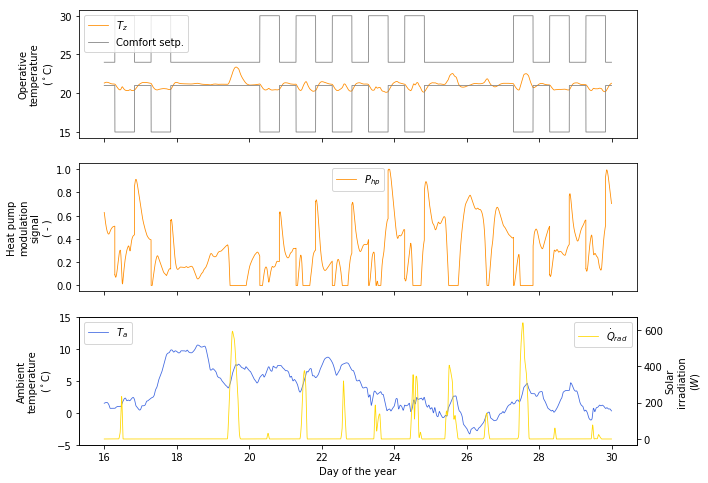

In [19]:
get_and_plot_results(testid, start_time=start_time_days*24*3600, final_time=np.inf)

---

### Assessing Your Own Control Algorithm

Now that we know how to initialize a test case, advance a simulation, and obtain results, it is time to implement and assess our own control algorithm. 
For this example we are going to implement a very simple proportional controller that will determine the heat pump modulation signal as a function of the zone operative temperature.
No other variables need to be overwritten since the subcontroller C2 will switch on the heat pump fan and the circulation pump every time we send a control signal with `oveHeaPumY_u > 0`. 
Only two parameters need tuning: the temperature set point and the proportional gain: 

In [20]:
class Controller_Proportional(object):
    
    def __init__(self, TSet=273.15+21, k_p=10.):
        '''Constructor.

        Parameters
        ----------
        TSet : float, optional
            Temperature set-point in Kelvin.
        k_p : float, optional
            Proportional gain. 
            
        '''
        
        self.TSet = TSet
        self.k_p  = k_p
    
    def compute_control(self, y):
        '''Compute the control input from the measurement.
    
        Parameters
        ----------
        y : dict
            Contains the current values of the measurements.
            {<measurement_name>:<measurement_value>}
    
        Returns
        -------
        u : dict
            Defines the control input to be used for the next step.
            {<input_name> : <input_value>}
    
        '''
    
        # Compute control
        if y['reaTZon_y']<self.TSet:
            e = self.TSet - y['reaTZon_y']
        else:
            e = 0
    
        value = self.k_p*e
        u = {'oveHeaPumY_u':value,
             'oveHeaPumY_activate': 1}
    
        return u

Now let's initialize the test case in the same scenario that we used to obtain the baseline controller KPIs, that is, the peak heating period with dynamic pricing.  We also define the control step to be one hour.  This is equal to the default but maybe a tunable parameter later. 
After that, we instantiate the controller and define a simulation loop using the BOPTEST API.
Note that the test case will return an empty dictionary when the testing period has elapsed, such that we can loop over the returned measurements without having to infer when the simulation time should end.

In [21]:
# Initialize scenario
y = requests.put('{0}/scenario/{1}'.format(url, testid), 
                 data={'time_period':'peak_heat_day',
                       'electricity_price':'dynamic'}).json()['payload']['time_period']
# Set control step
requests.put('{0}/step/{1}'.format(url, testid), data={'step':3600})
# Instantiate controller
con = Controller_Proportional(TSet=273.15+21, k_p=5.)
# Simulation loop
from IPython.display import clear_output
while y:
    # Clear the display output at each step
    clear_output(wait=True)
    # Print the current operative temperature and simulation time
    print('-------------------------------------------------------------------')
    print('Operative temperature [degC]  = {:.2f}'.format(y['reaTZon_y']-273.15))
    simulation_time_days = y['time']/3600/24
    print('Simulation time [elapsed days] = {:.2f}'.format((simulation_time_days - \
                                                    start_time_days)))
    print('-------------------------------------------------------------------')
    # Compute control signal 
    u = con.compute_control(y)
    # Advance simulation with control signal
    y = requests.post('{0}/advance/{1}'.format(url, testid), data=u).json()['payload']    


-------------------------------------------------------------------
Operative temperature [degC]  = 20.73
Simulation time [elapsed days] = 1.00
-------------------------------------------------------------------


KeyboardInterrupt: 

After the simulation is done, we can plot the results, obtain KPIs, and compare with those obtained for the baseline controller, which were saved in the variable `kpis_bas`.

In [ ]:
get_and_plot_results(testid, start_time=start_time_days*24*3600, final_time=np.inf)

In [ ]:
kpis_con = requests.get('{0}/kpi/{1}'.format(url, testid)).json()['payload']
kpis_con

In [ ]:
kpis_bas

Our controller does not obviously improve the results so far. 
While it does use less energy, it approximately doubles the thermal discomfort. 
You may want to re-run the previous cells with different values of `TSet`, `k_p`, and control step to find a good balance between comfort and operational cost.  We will continue this in Part 4.
Feel free to also explore viewing other measurements or changing the test case scenario.

### Stopping the Test Case

Now that we're finished evaluating the performance of our controller, let's stop the test case instance in order to free up web-service resources for other test cases.  Feel free to go back to the beginning of this Part 2, however, to re-select a test case and begin again.

In [ ]:
# Set to true if want to stop test case
# Note: Part 4. code will not work if test case is stopped and not restarted first
stop = False
if stop:
  requests.put('{0}/stop/{1}'.format(url, testid))

---

# **Part 3: (Presentation) Example Development and Evaluation of an MPC Controller**

An example of the implementation and evaluation of an MPC for the BOPTEST test case of this tutorial is given in the accompanying presentation *Example Development and Evaluation of an MPC Controller*.

---

# **Part 4: (Exercise): Improving Controller Performance and Reporting Results**

The goal of this part of the tutorial is to optimize the controller developed in Exercise 1 by further tuning for energy cost and thermal discomfort reduction. Team-work in groups of 2-3 is encouraged for this.  Feel free to use the code and controller developed in Part 2 as a starting basis or create your own.  Either way, make sure you are testing your controller on:

*   Test case = `bestest_hydronic_heat_pump`
*   Scenario = `peak_heat_day` time period and `dynamic` electricity price

## Report Your Results

A key aspect of BOPTEST is reporting your results for comparison against other control algorithms.  Therefore, let's collect each team's KPI results to keep track of how our test controller can be improved.  Report your latest KPI values and brief description of key controller innovation(s) after 10, 20, and 30 minutes of work to the appropriate worksheets at [BOPTEST RESULTS BS2021](https://docs.google.com/spreadsheets/d/147my370AFpldpdpS3jQclzc8roVIFPTamB_iCVjuLAk/edit?usp=sharing).  After 30 minutes of work, we will discuss the results!



## Try Using Forecasts

Though we did not cover this in Part 2, the presentation in Part 3 showed that the use of forecasts could help a controller deal with time delay associated with the thermal mass of the floor heating system.  In BOPTEST, forecasts provide you with things like weather forecasts, internal load and occupancy forecasts, electricity price forecasts, and set point values for zone temperature and CO2 concentration utilized for thermal and IAQ discomfort KPI calculations.  

Use the `PUT /forecast_parameters` BOPTEST API endpoint with parameters `horizon` and `interval` in seconds to set a forecast horizon and data interval.  Then, use the `GET /forecast` BOPTEST API endpoint to retrieve the forecast data, which will start from the current simulation time.


In [ ]:
# Set forecast parameters
requests.put('{0}/forecast_parameters/{1}'.format(url, testid), 
             data={'horizon':6*3600, 'interval':1*3600})
# Get forecast data
w = requests.get('{0}/forecast/{1}'.format(url, testid)).json()['payload']
print('Outside Air Dry Bulb Temperature Forecast [K]--------------------------')
print(w['TDryBul'])
print('Dynamic Electricty Price Forecast [Euro/kWh]---------------------------')
print(w['PriceElectricPowerDynamic'])
print('Occupancy Count Forecast for Zone "1" [ppl]----------------------------')
print(w['Occupancy[1]'])
print('Upper Operative Temperature Target Forecast for Zone "1" [K]-----------')
print(w['UpperSetp[1]'])
print('Lower Operative Temperature Target Forecast for Zone "1" [K]-----------')
print(w['LowerSetp[1]'])
print('Simulation Time [s]----------------------------------------------------')
print(w['time'])

---

# **Part 5: Continued Usage and Wrap-Up**

Now that you've had some experience working with BOPTEST, here are a few items to know for continuing to use BOPTEST after the workshop.

## Local Usage

As mentioned in the Goals and Outline section, we have used a web-based version of BOPTEST for this workshop.  You may deploy and work with BOPTEST on your own computer too.  Directions are described in the [BOPTEST User Guide](https://ibpsa.github.io/project1-boptest/docs-userguide/index.html).

## Follow-up Exercise

We invite you to continue exploring and using BOPTEST for your own work.  With this invitation comes an opportunity to complete a follow-up exercise meant to continue supporting your use of BOPTEST in this way.  

If interested, use your own, innovative methods to design a controller for the `bestest_hydronic_heat_pump` test case.  Test your controller(s) on different scenarios, evaluate their performance using simulation data, and benchmark their performance with the BOPTEST KPI's.  Then, in approximately two months time, we will schedule a follow-up meeting with participants and members of the BOPTEST project team to allow participants to present their work, get support from BOPTEST developers, and offer feedback to improve BOPTEST. 

Please indicate your anticipation to participate in this follow-up exercise in the Feedback below.



## Feedback

Thank you for attending this workshop and for your interest in BOPTEST!  We hope you have enjoyed working with BOPTEST and will find it useful for your own work.  We would appreciate if you would provide your feedback on this workshop and BOPTEST in general using the following form:

[Feedback Form](https://forms.gle/cAATBtBBz6iYgVm16)

## Stopping the current running testcase:

In [23]:
stop_response = requests.put('{0}/stop/{1}'.format(url, testid))
if stop_response.status_code == 200:
  print("Successfully stopped the test!")
else:
  print("Couldn't stop test with status code: {stop_response.status_code}!")


Successfully stopped the test!
